# CASO DE ESTUDIO 2 - MODELO DE REDES CONVOLUCIONALES


## 1. Business Case Discovery

### 1.1 Contexto del negocio y antecedentes (resumido)
El reconocimiento automatico de los digitos en el proceso de clasificacion de correspondencia puede agilizar y reducir costos operativos

### 1.2 Objetivo del proyecto
Desarrollar un sistema de reconocimiento de digitos que identifique digitos y permita automatizar el ruteo y clasificacion en funcion del codigo postal

### 1.3 Metricas de exito
- **Precision(Accuracy)**: Porcentaje de digitos reconocidos correctamente
- **Tiempo de inferencia**: Tiempo requerido para procesar las imagenes
- **Numero de parametros**: Comparacion de la eficiencia del modelo, evaluando complejidad y generalizacion

### 1.4 Desafios y consideraciones
- **Calidad y variabilidad de las imagenes**
- **Overfitting y Underfitting**

--- 

## 2. Data processing
Se usara el dataset de MNIST.

70.000 imagenes en escala de grises con tamaño de imagen 28x28 y de digitos manuscritos del 0 a 9

#### Importacion de librerias

In [67]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image
import io
import base64
import os
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping


#### Carga de datos

In [68]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


### Visualizacion de los datos

#### Algunos ejemplos de imagenes

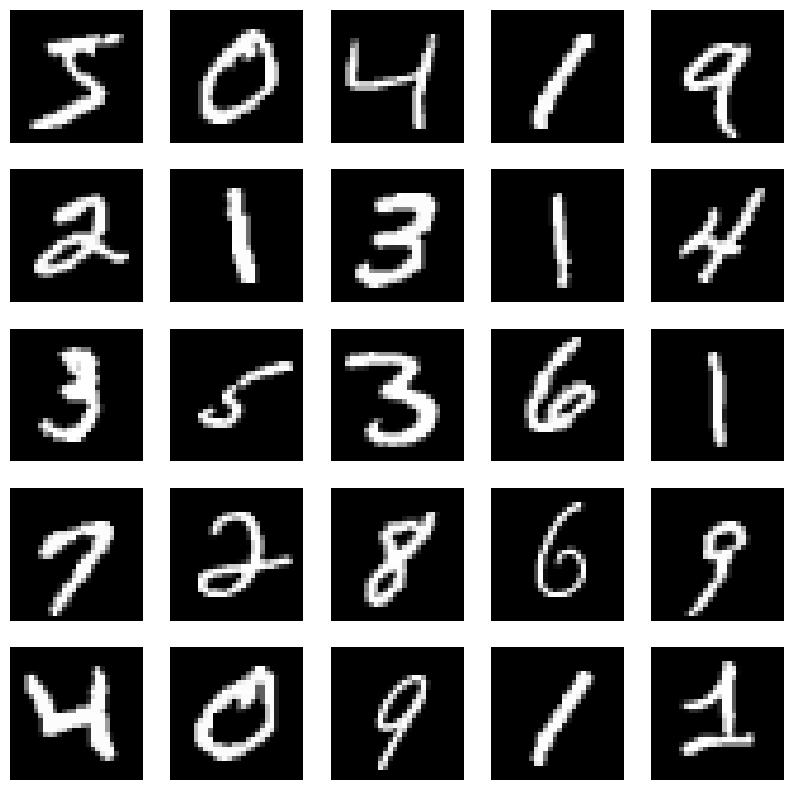

In [69]:
# Visualizar algunas imágenes del dataset
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')
plt.show()

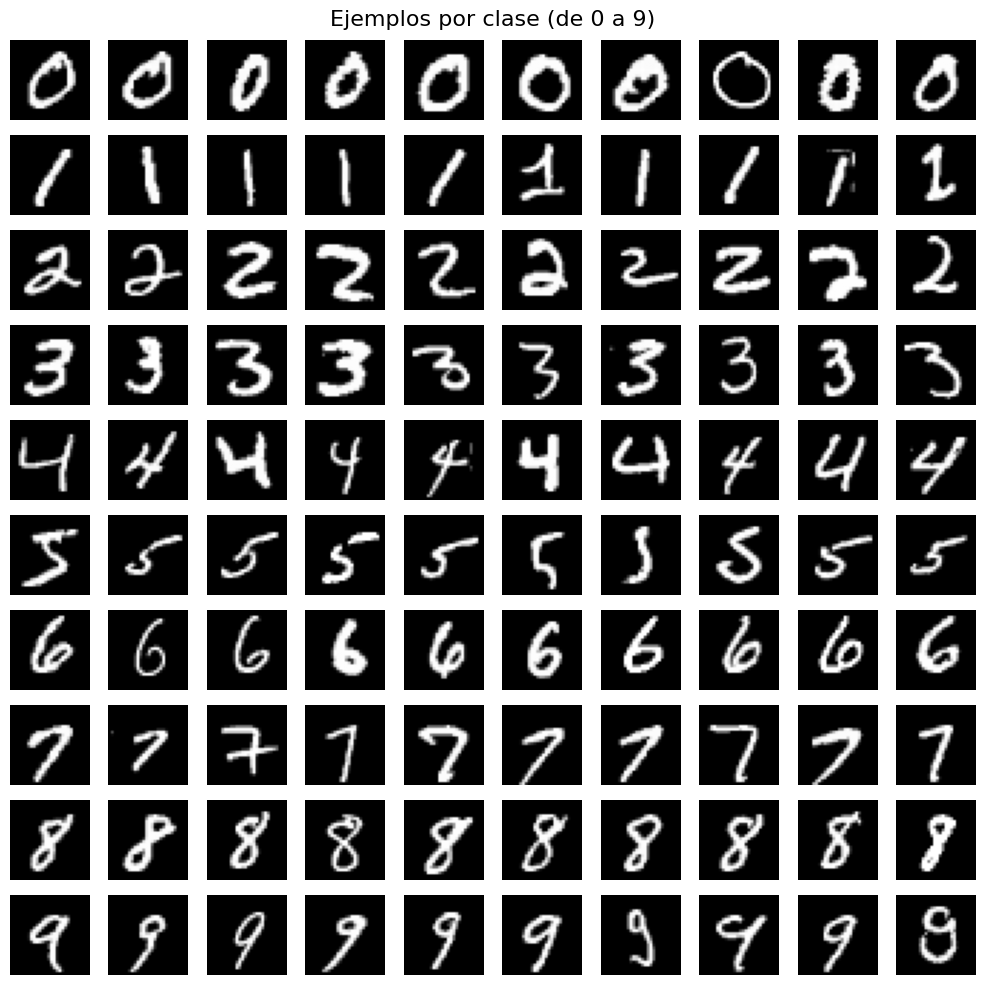

In [70]:
import matplotlib.pyplot as plt

def show_examples_by_class(x_data, y_data, samples_per_class=10):
    plt.figure(figsize=(samples_per_class, 10))
    for digit in range(10):
        idxs = np.where(y_data == digit)[0][:samples_per_class]
        for i, idx in enumerate(idxs):
            plt_idx = digit * samples_per_class + i + 1
            plt.subplot(10, samples_per_class, plt_idx)
            plt.imshow(x_data[idx].reshape(28, 28), cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.ylabel(str(digit), fontsize=14)
    plt.suptitle("Ejemplos por clase (de 0 a 9)", fontsize=16)
    plt.tight_layout()
    plt.show()

# Llama a la función con tus datos
show_examples_by_class(x_train, y_train)


#### Representacion de los datos

In [71]:

def representar_dataset(y_train=y_train):
    # Contar cuántos hay de cada dígito
    unique, counts = np.unique(y_train, return_counts=True)
    percentages = counts / counts.sum() * 100  # Convertimos a porcentaje

    # Crear DataFrame con los valores de clase y sus frecuencias
    df_freq = pd.DataFrame({'Dígito': unique, 'Cantidad': counts})
    df_freq = df_freq.set_index('Dígito')

    fig = plt.figure(figsize=(14, 10))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

    # Histograma de las etiquetas (dígitos)
    ax1 = fig.add_subplot(gs[0, 0])
    sns.countplot(x=y_train, ax=ax1)
    ax1.set_title("Distribución de clases en dataset MNIST")
    ax1.set_xlabel("Dígitos")
    ax1.set_ylabel("Cantidad de imágenes")
    ax1.grid(True, axis='y', linestyle='-')

    # Histograma de porcentajes
    ax2 = fig.add_subplot(gs[0, 1])
    sns.barplot(x=unique, y=percentages, ax=ax2)
    ax2.set_title("Distribución porcentual de las clases en MNIST")
    ax2.set_xlabel("Dígitos")
    ax2.set_ylabel("Porcentaje (%)")
    ax2.set_ylim(0, max(percentages) + 2)
    for i, v in enumerate(percentages):
        ax2.text(i, v + 0.5, f"{v:.2f}%", ha='center', rotation=90, size=12)

    # Mapa de calor
    ax3 = fig.add_subplot(gs[1, :])
    sns.heatmap(df_freq.T, annot=True, fmt='d', cmap="YlGnBu", cbar=True, ax=ax3)
    ax3.set_title("Distribución de dígitos (heatmap)")
    ax3.set_xlabel("Dígito")
    ax3.set_ylabel("")
    for text in ax3.texts:
        text.set_rotation(45)
        text.set_size(16)

    plt.tight_layout(pad=3.0)
    plt.show()



In [72]:
def show_images(title, indices, x_train=x_train, y_train=y_train):
    plt.figure(figsize=(15, 2))
    for i, idx in enumerate(indices):
        plt.subplot(1, 10, i+1)
        plt.imshow(x_train[idx].reshape(28, 28), cmap='gray')
        plt.title(f"{y_train[idx]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


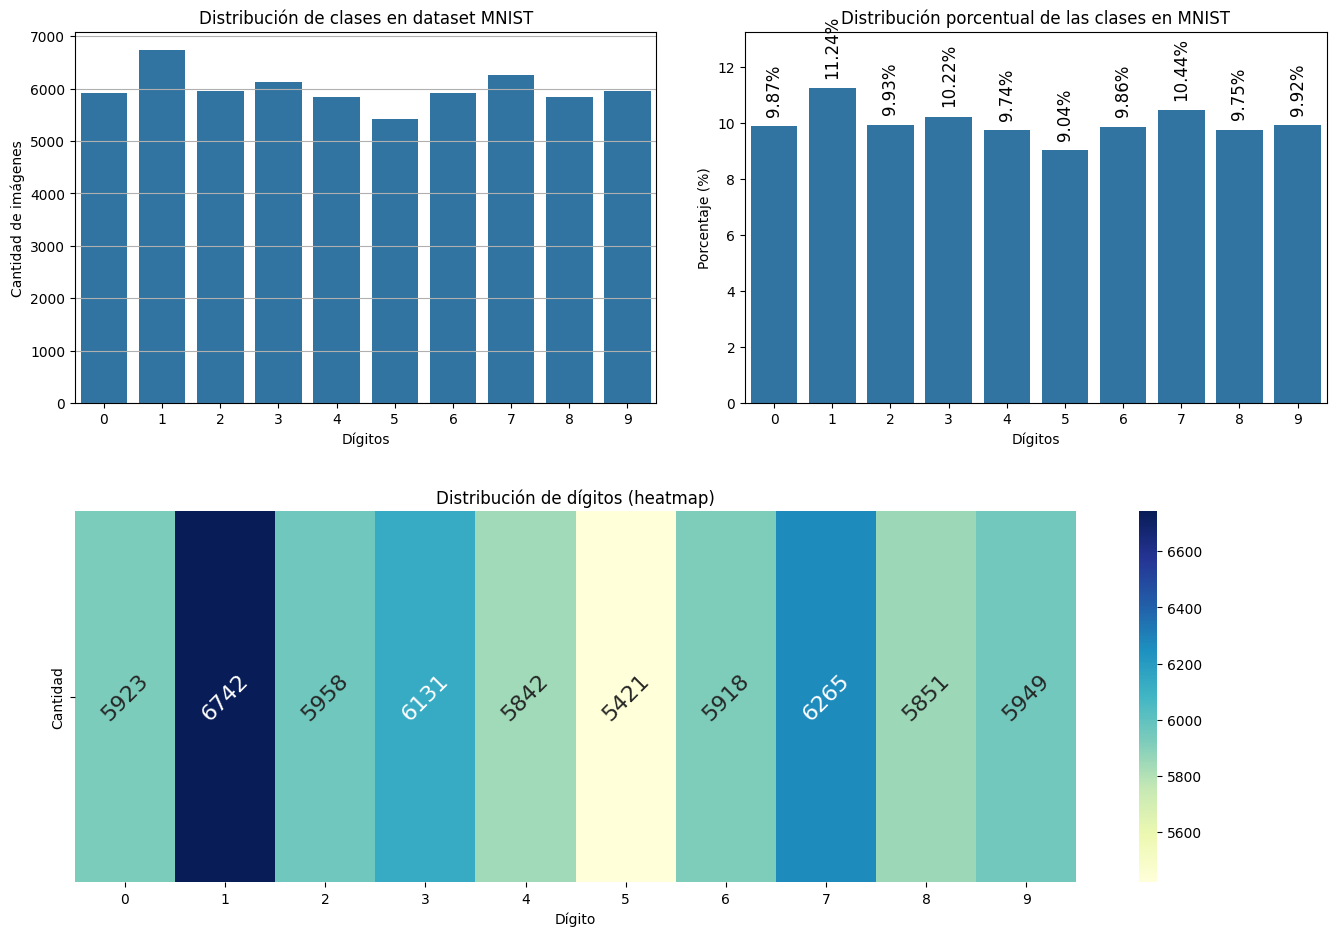

In [73]:
representar_dataset(y_train=y_train)

#### Detección de posibles anomalías

##### Definicion de threshold

In [74]:
pixel_sums = x_train.reshape(x_train.shape[0], -1).sum(axis=1)

print("Mínima suma de píxeles:", pixel_sums.min())
print("Máxima suma de píxeles:", pixel_sums.max())

threshold_low = np.percentile(pixel_sums, 0.1)   # Umbral bajo (0.1%)
threshold_high = np.percentile(pixel_sums, 98) # Umbral alto (98%)

low_pixel_idxs = np.where(pixel_sums <= threshold_low)[0]
high_pixel_idxs = np.where(pixel_sums >= threshold_high)[0]


Mínima suma de píxeles: 5086
Máxima suma de píxeles: 79483


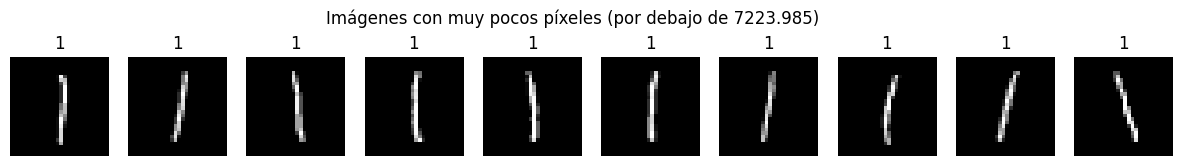

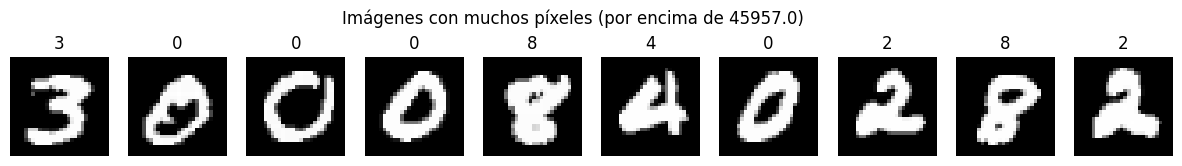

In [75]:

show_images(f"Imágenes con muy pocos píxeles (por debajo de {threshold_low})", low_pixel_idxs[:10])
show_images(f"Imágenes con muchos píxeles (por encima de {threshold_high})", high_pixel_idxs[:10])


Número de imágenes con píxeles altos: 1201


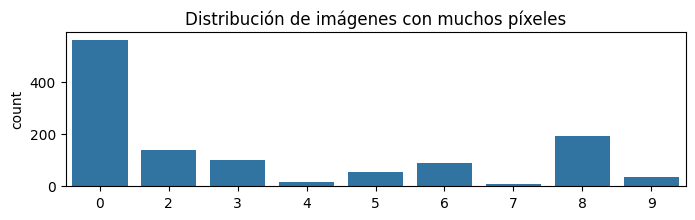

In [76]:
high_pixel_labels = y_train[high_pixel_idxs]

# Contar cuántas imágenes tienen píxeles altos
print(f"Número de imágenes con píxeles altos: {len(high_pixel_idxs)}")

plt.figure(figsize=(8,2))
sns.countplot(x=high_pixel_labels)
plt.title("Distribución de imágenes con muchos píxeles")
plt.show()

##### Limpieza quitando los que pasan de umbral

In [77]:
print(f"Tamaño original de x_train: {x_train.shape}")
print(f"Tamaño original de y_train: {y_train.shape}")

# Eliminar las imágenes con píxeles altos
x_train_cleaned = np.delete(x_train, high_pixel_idxs, axis=0)
y_train_cleaned = np.delete(y_train, high_pixel_idxs, axis=0)

print(f"Nuevo tamaño de x_train: {x_train_cleaned.shape}")
print(f"Nuevo tamaño de y_train: {y_train_cleaned.shape}")

Tamaño original de x_train: (60000, 28, 28)
Tamaño original de y_train: (60000,)
Nuevo tamaño de x_train: (58799, 28, 28)
Nuevo tamaño de y_train: (58799,)


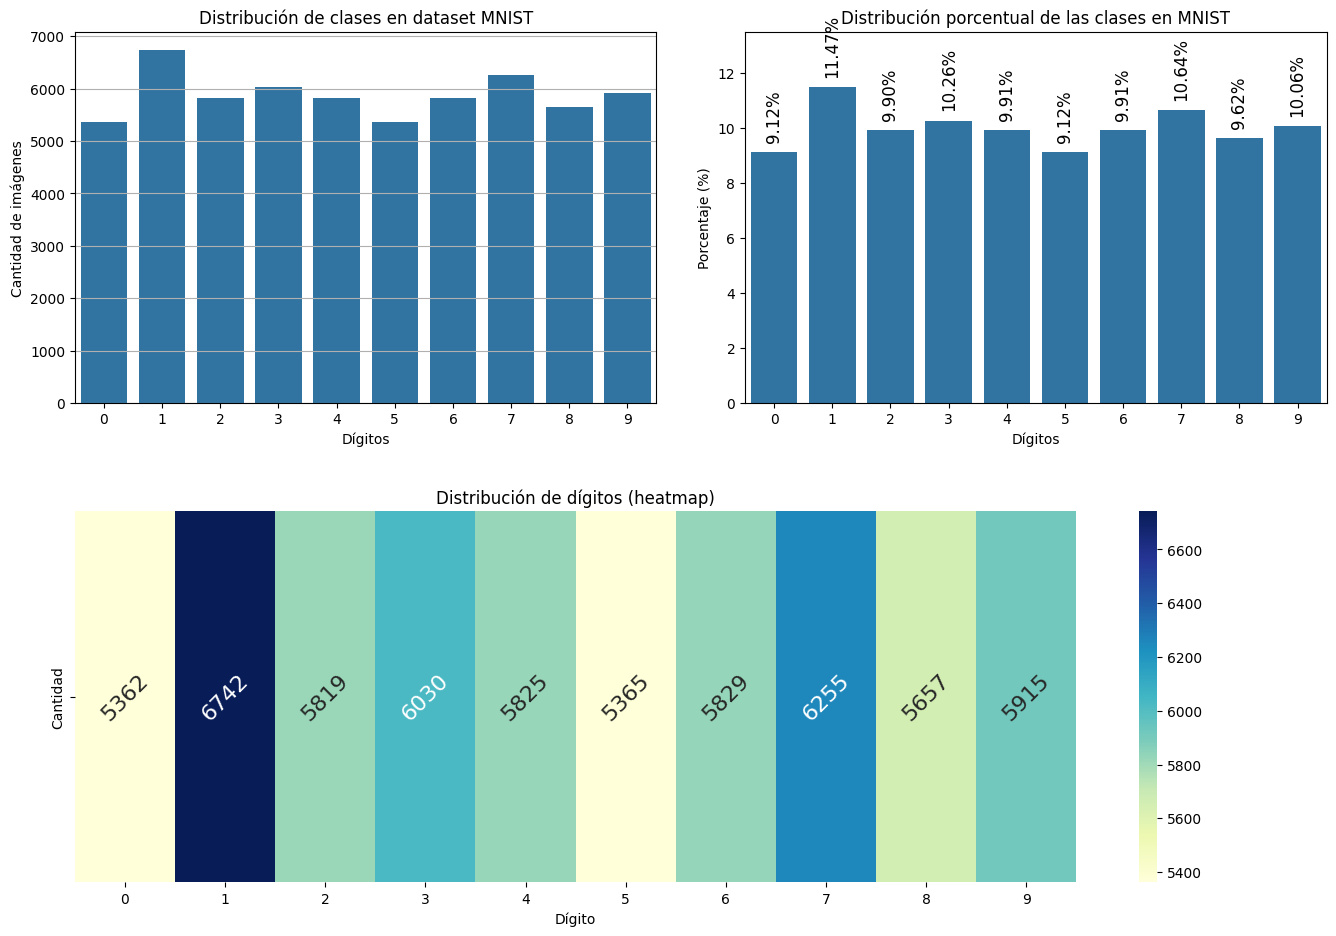

In [78]:
representar_dataset(y_train=y_train_cleaned)

##### Definicion de nuevo threshold

In [79]:
pixel_sums_cleaned = x_train_cleaned.reshape(x_train_cleaned.shape[0], -1).sum(axis=1)

print("Cleaned - Mínima suma de píxeles:", pixel_sums_cleaned.min())
print("Cleaned - Máxima suma de píxeles:", pixel_sums_cleaned.max())

threshold_low_cleaned = np.percentile(pixel_sums_cleaned, 0.1)   # Umbral bajo (0.1%)
threshold_high_cleaned = np.percentile(pixel_sums_cleaned, 98) # Umbral alto (98%)

low_pixel_idxs_cleaned = np.where(pixel_sums_cleaned <= threshold_low_cleaned)[0]
high_pixel_idxs_cleaned = np.where(pixel_sums_cleaned >= threshold_high_cleaned)[0]


Cleaned - Mínima suma de píxeles: 5086
Cleaned - Máxima suma de píxeles: 45949


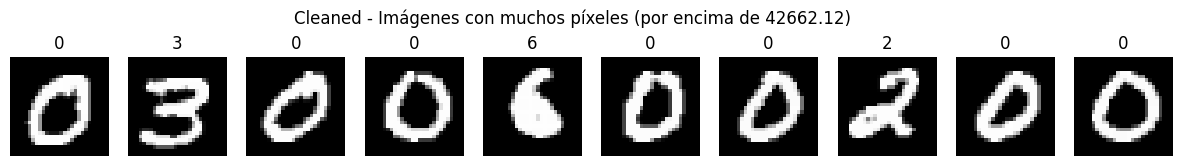

In [80]:
show_images(f"Cleaned - Imágenes con muchos píxeles (por encima de {threshold_high_cleaned})",
            high_pixel_idxs_cleaned[:10],
            x_train=x_train_cleaned, 
            y_train=y_train_cleaned)


Cleaned - Número de imágenes con píxeles altos: 1176


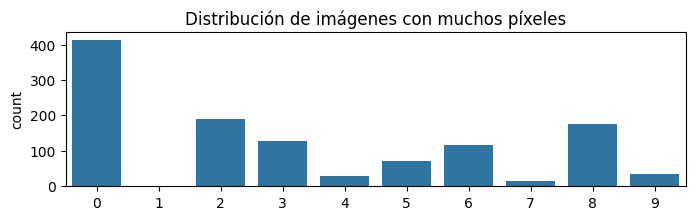

In [81]:
high_pixel_labels_cleaned = y_train_cleaned[high_pixel_idxs_cleaned]

# Contar cuántas imágenes tienen píxeles altos
print(f"Cleaned - Número de imágenes con píxeles altos: {len(high_pixel_idxs_cleaned)}")

plt.figure(figsize=(8,2))
sns.countplot(x=high_pixel_labels_cleaned)
plt.title("Distribución de imágenes con muchos píxeles")
plt.show()

##### Limpieza quitando los que pasan del nuevo umbral 

In [82]:
print(f"Tamaño original de x_train_cleaned: {x_train_cleaned.shape}")
print(f"Tamaño original de y_train_cleaned: {y_train_cleaned.shape}")

high_pixel_non_zero_idxs = high_pixel_idxs_cleaned[y_train_cleaned[high_pixel_idxs_cleaned] != 0]

# Eliminar las imágenes con píxeles altos
x_train_final = np.delete(x_train_cleaned, high_pixel_non_zero_idxs, axis=0)
y_train_final = np.delete(y_train_cleaned, high_pixel_non_zero_idxs, axis=0)

print(f"Nuevo tamaño de x_train_final: {x_train_final.shape}")
print(f"Nuevo tamaño de y_train_final: {y_train_final.shape}")

Tamaño original de x_train_cleaned: (58799, 28, 28)
Tamaño original de y_train_cleaned: (58799,)
Nuevo tamaño de x_train_final: (58037, 28, 28)
Nuevo tamaño de y_train_final: (58037,)


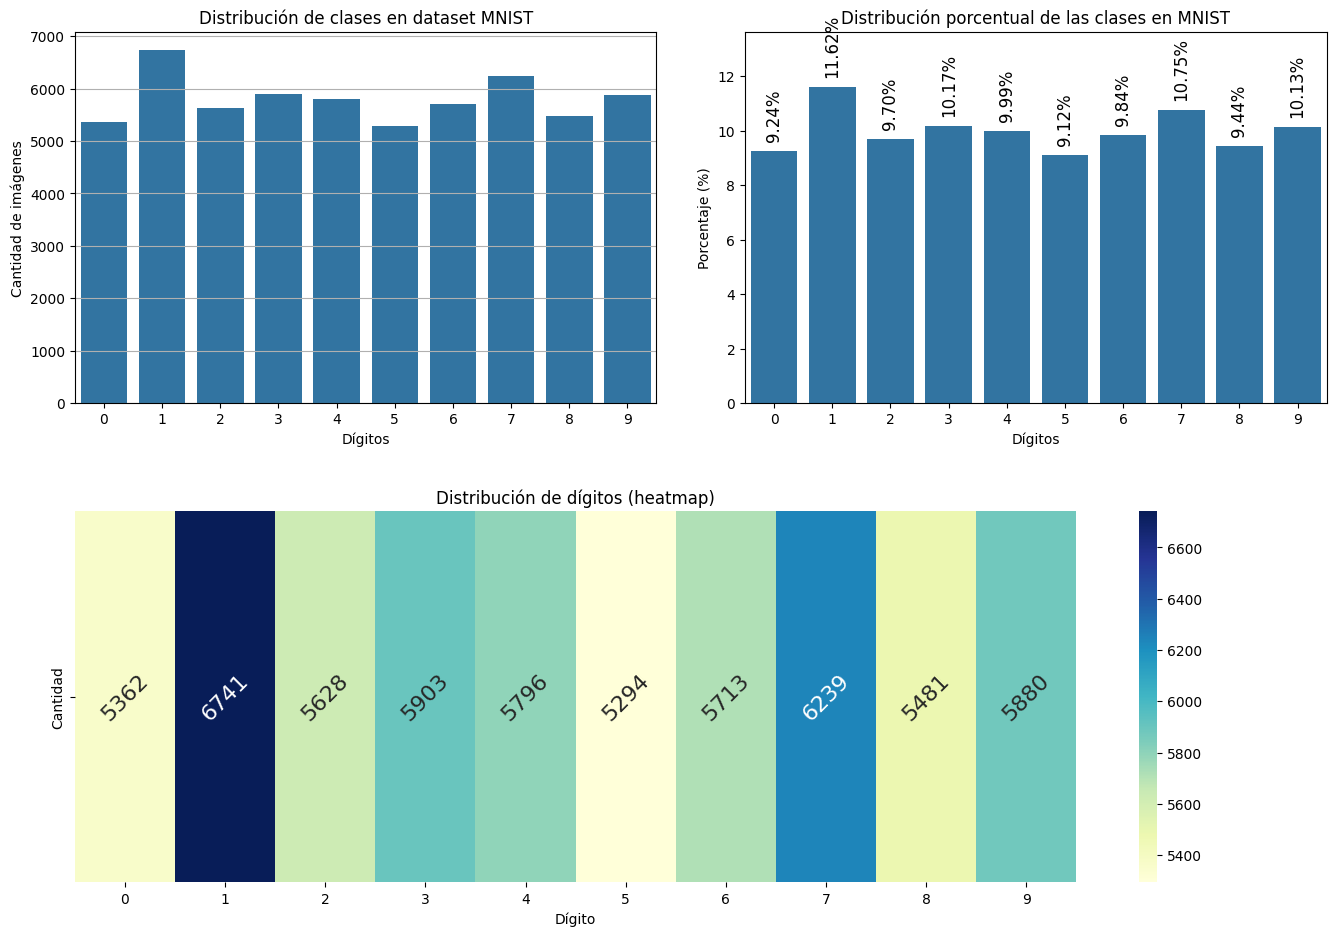

In [83]:
representar_dataset(y_train=y_train_final)


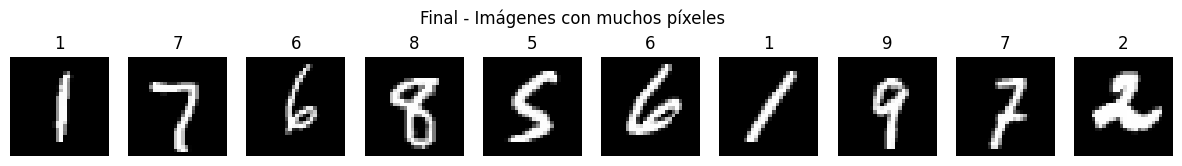

In [84]:

show_images(f"Final - Imágenes con muchos píxeles", high_pixel_non_zero_idxs[:10], x_train=x_train_final, y_train=y_train_final)


##### Resumen de los cambios hechos

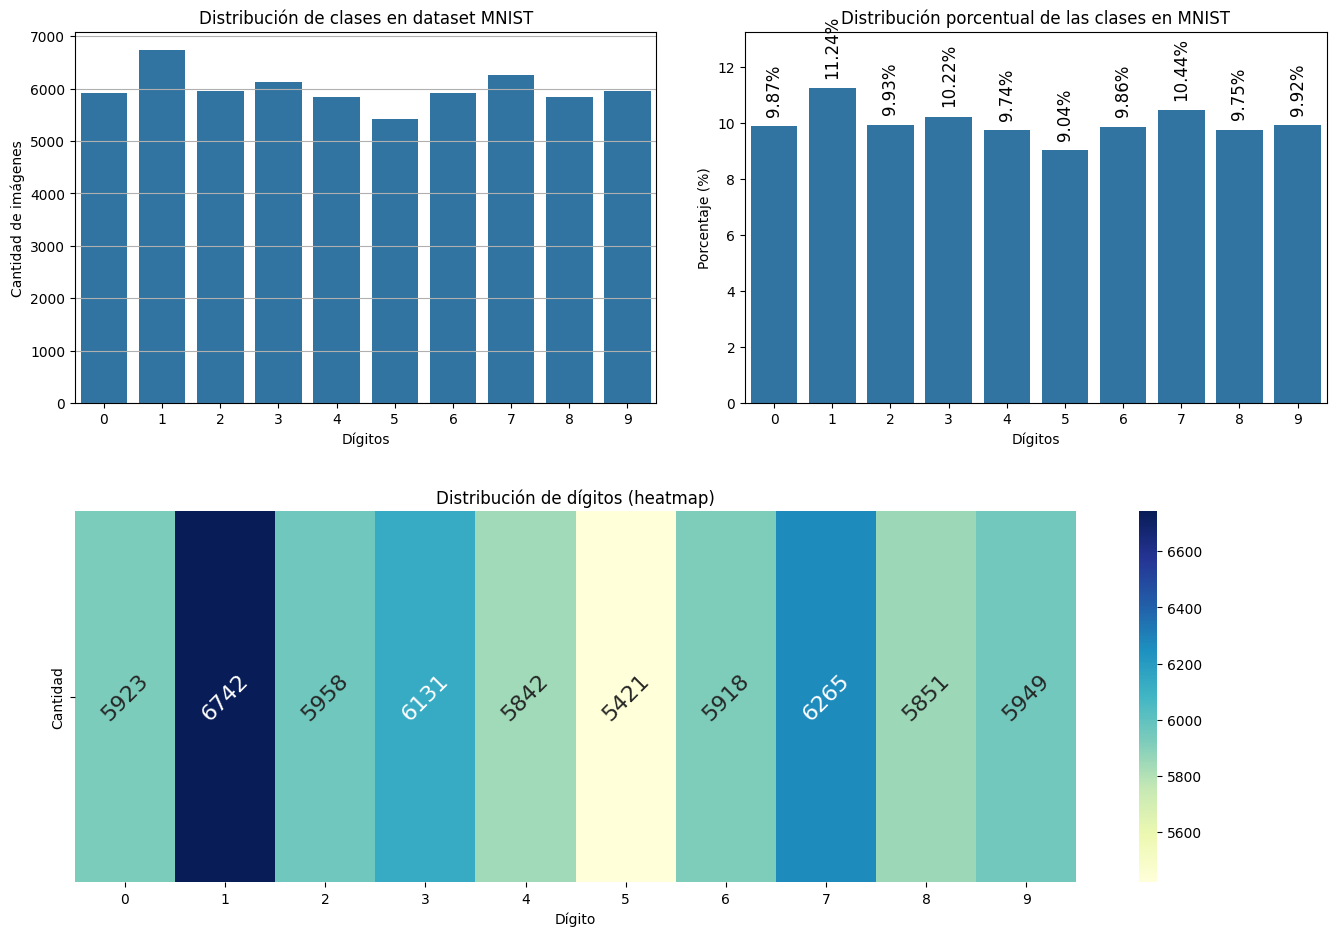

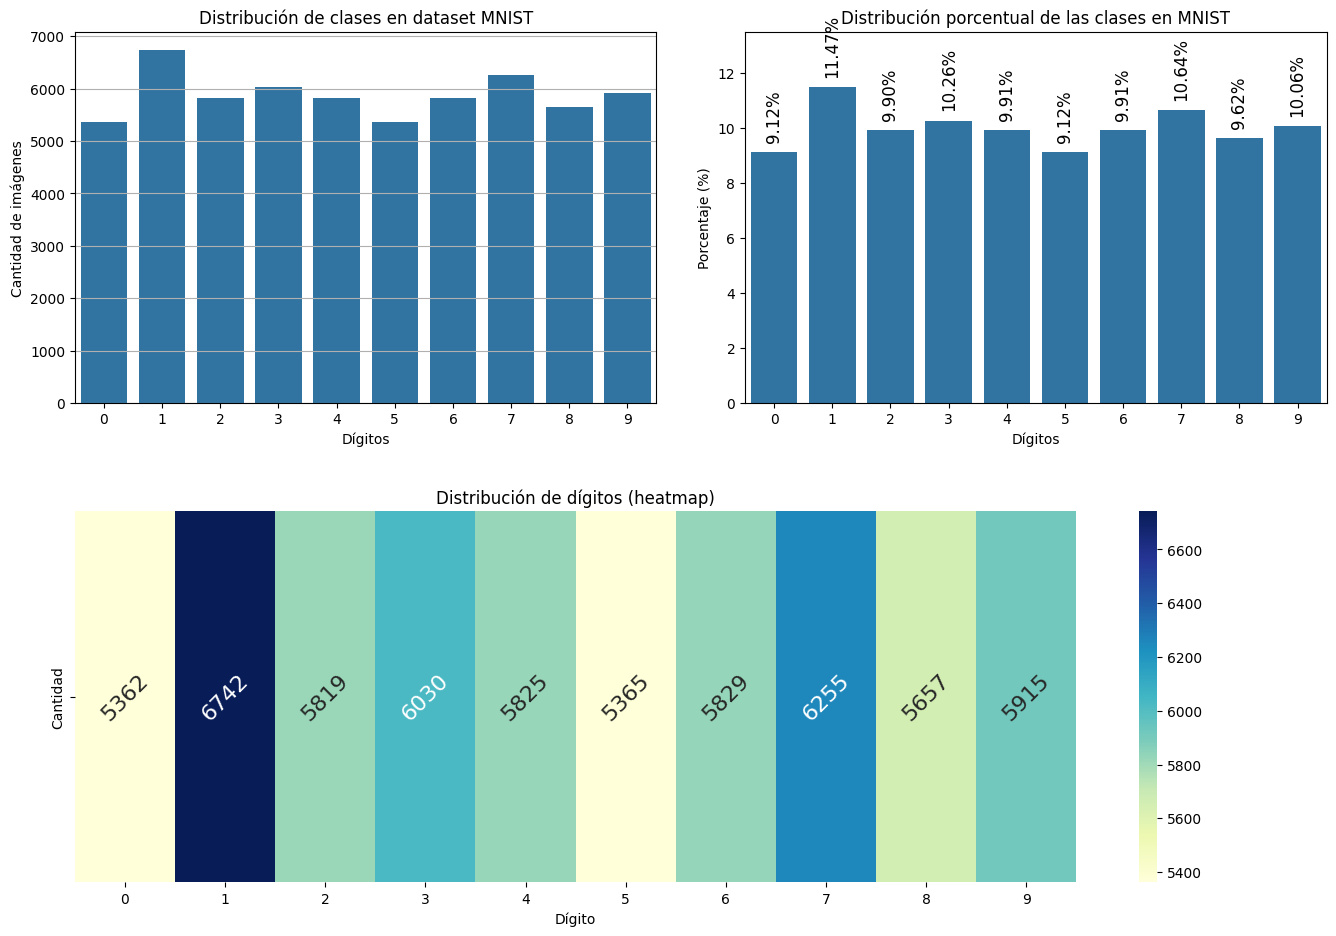

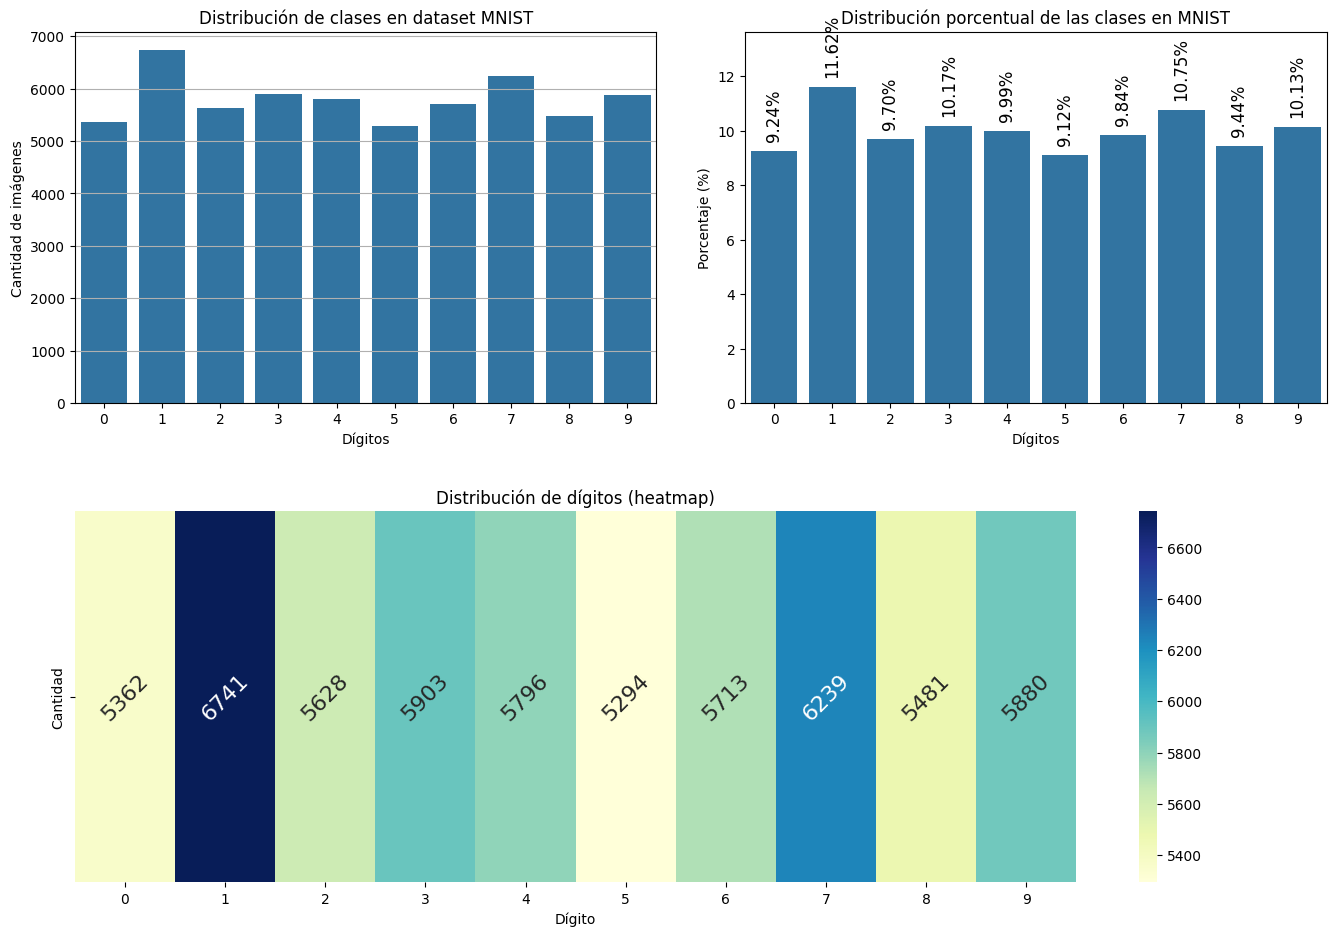

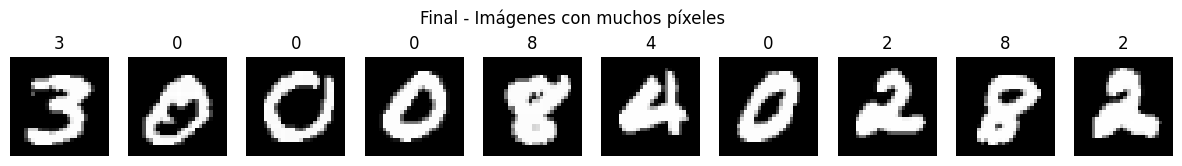

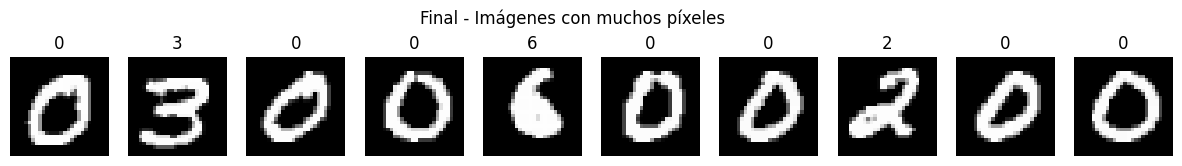

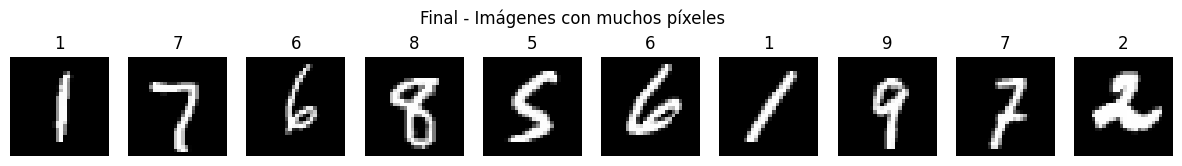

In [85]:
representar_dataset(y_train=y_train)
representar_dataset(y_train=y_train_cleaned)
representar_dataset(y_train=y_train_final)
show_images(f"Final - Imágenes con muchos píxeles", high_pixel_idxs[:10], x_train=x_train, y_train=y_train)
show_images(f"Final - Imágenes con muchos píxeles", high_pixel_idxs_cleaned[:10], x_train=x_train_cleaned, y_train=y_train_cleaned)
show_images(f"Final - Imágenes con muchos píxeles", high_pixel_non_zero_idxs[:10], x_train=x_train_final, y_train=y_train_final)

### Normalizacion de las imagenes

In [86]:
# Normalizar las imágenes a un rango [0, 1]
x_train = x_train_final / 255.0
x_test = x_test / 255.0


In [87]:
# Redimensionar para agregar la dimensión de canal
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print(x_train.shape)
print(x_test.shape)


(58037, 28, 28, 1)
(10000, 28, 28, 1)


In [88]:
# from sklearn.model_selection import train_test_split

# # Dividir el conjunto de datos de entrenamiento en entrenamiento y validación
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train_final, test_size=0.15, stratify=y_train_final)

# # Verificar el tamaño de cada conjunto
# print(f"Tamaño del conjunto de entrenamiento: {x_train.shape}, Tamaño del conjunto de validación: {x_val.shape}")


##### Transformacion en one-hot

In [89]:
y_train_one_hot = tf.keras.utils.to_categorical(y_train_final, num_classes=10)
# y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=10)


## 3. Model planning

### 3.1 Definicion del problema
- Tipo de Problema: Clasificación de imágenes, donde cada imagen representa un dígito del 0 al 9
- Objetivo: Lograr una alta precision, minimizando errores

### 3.2 Arquitectura de la red neuronal
- Capas convolucionales: al menos 2, con filtros incrementando en cantidad (32 y 64)
- Capas de pooling: tras cada capa convolucional aplicar una de MaxPooling
- Capas de activacion: funciones ReLU en cada capa para evitar linealidad
- Capa final: una capa fully connected (dense) con salida de 10 (una para digito) y activacion softmax

In [94]:
def build_model(input_shape=(28,28,1), dropouts=[0.2,0.25,0.3], learning_rate=0.0001):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),

        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(dropouts[0]),

        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(dropouts[1]),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2'),
        tf.keras.layers.Dropout(dropouts[2]),

        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

    return model


In [95]:
# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# K-Fold cross validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
fold = 1
histories = []

# Almacenar metricas de cada fold
best_accuracy = 0
best_model = None
accuracies = []
val_accuracies = []

In [96]:
if tf.config.list_physical_devices("GPU"):
    print("Usando GPU")
    with tf.device("/GPU:0"):
        for train_index, val_index in kf.split(x_train):
            print(f"📁 Fold {fold}")
            
            x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
            y_train_fold, y_val_fold = y_train_one_hot[train_index], y_train_one_hot[val_index]

            model = build_model(input_shape=x_train_fold.shape[1:], 
                                dropouts=[0.15,0.2,0.25], 
                                learning_rate=0.0001
            )
            
            # Entrenamiento con early stopping
            history = model.fit(x_train_fold, y_train_fold,
                                validation_data=(x_val_fold, y_val_fold),
                                epochs=10,
                                batch_size=64,
                                callbacks=[early_stop],
                                verbose=1)

            histories.append(history)
            
            # Guardar el mejor modelo según la precisión de validación
            val_acc = history.history['val_accuracy'][-1]
            accuracies.append(history.history['accuracy'][-1])
            val_accuracies.append(val_acc)
            
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                best_model = model  # Guardamos el mejor modelo
            
            fold += 1
        # print("Dispositivo en el que se ejecuta TensorFlow:", tf.test.gpu_device_name())
        # model.fit(x_train, y_train_one_hot, epochs=10, batch_size=16, validation_data=(x_val, y_val_one_hot))
else:
    print("NONO")

Usando GPU
📁 Fold 1
Epoch 1/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.6653 - loss: 2.8639 - val_accuracy: 0.9537 - val_loss: 1.0958
Epoch 2/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9341 - loss: 1.0290 - val_accuracy: 0.9703 - val_loss: 0.6311
Epoch 3/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9564 - loss: 0.6138 - val_accuracy: 0.9783 - val_loss: 0.3918
Epoch 4/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9639 - loss: 0.4067 - val_accuracy: 0.9809 - val_loss: 0.2666
Epoch 5/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9686 - loss: 0.2874 - val_accuracy: 0.9823 - val_loss: 0.1954
Epoch 6/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9727 - loss: 0.2148 - val_accuracy: 0.9838 - val_loss: 0.1527
Epoch 7/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9750 - loss: 0.1769 - val_accuracy: 0.9837 - val_loss: 0.1281
Epoch 8/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9768 - loss: 0.1

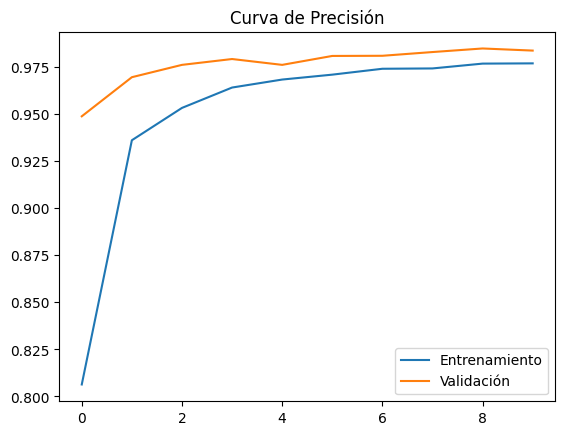

In [97]:
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.legend()
plt.title('Curva de Precisión')
plt.show()


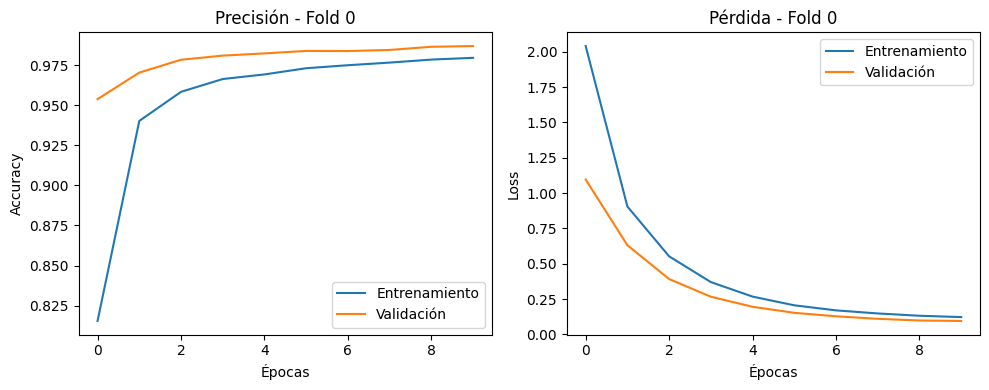

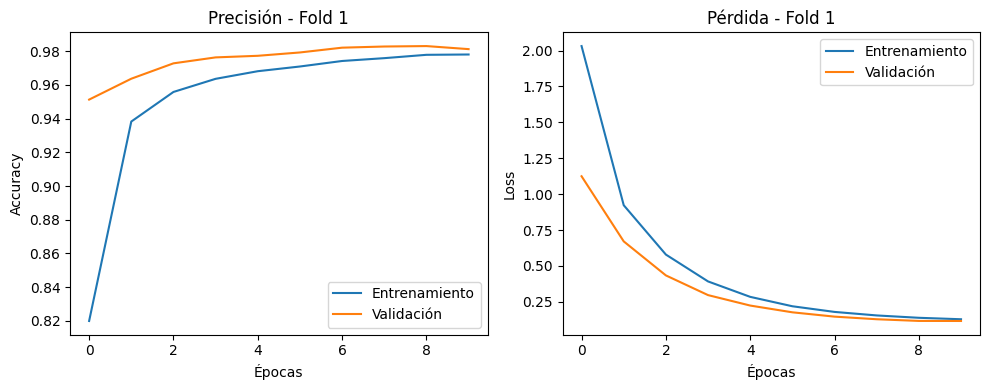

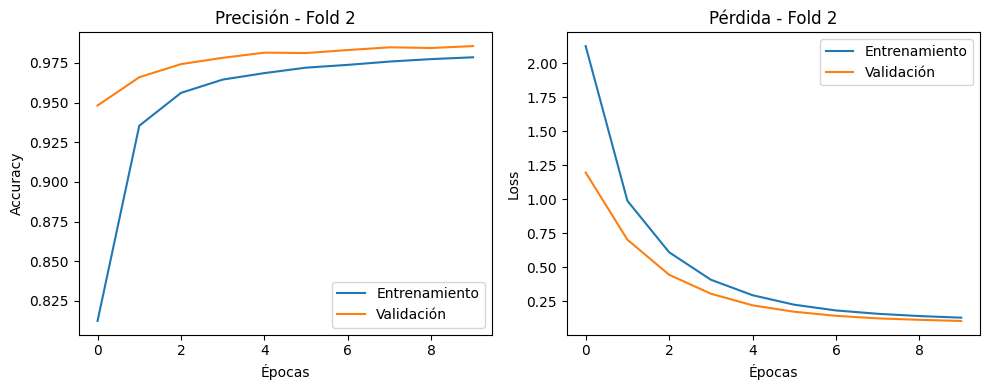

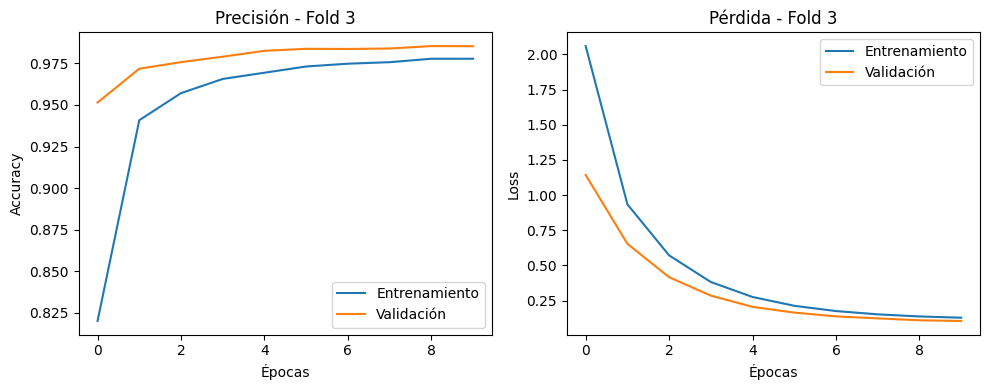

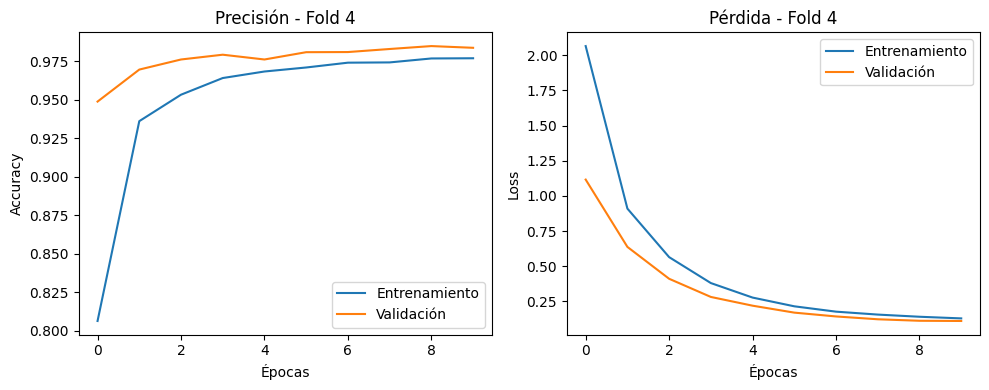

In [98]:
import matplotlib.pyplot as plt

def plot_training_curves(history, fold=0):
    plt.figure(figsize=(10, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title(f'Precisión - Fold {fold}')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title(f'Pérdida - Fold {fold}')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

for fold, history in enumerate(histories):
    plot_training_curves(history, fold=fold)


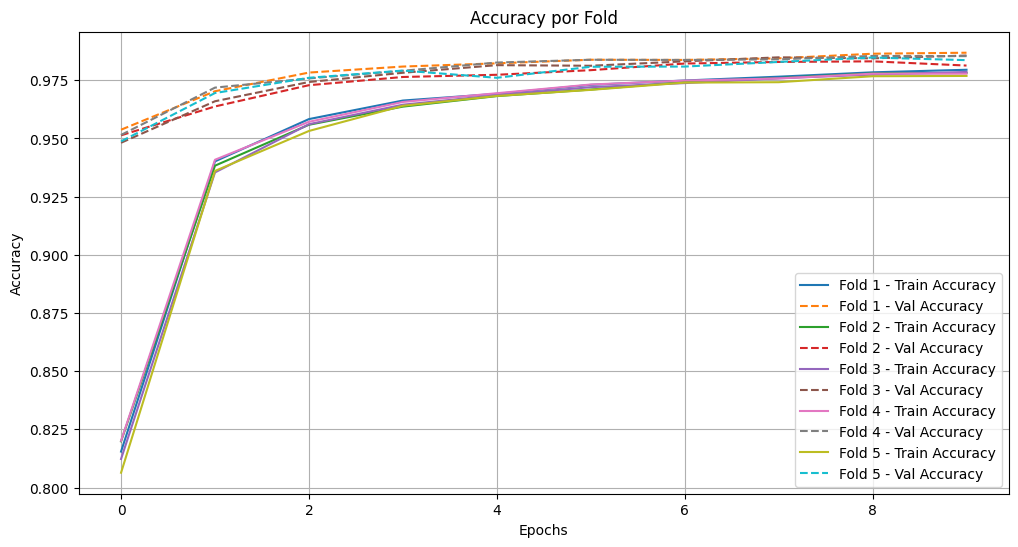

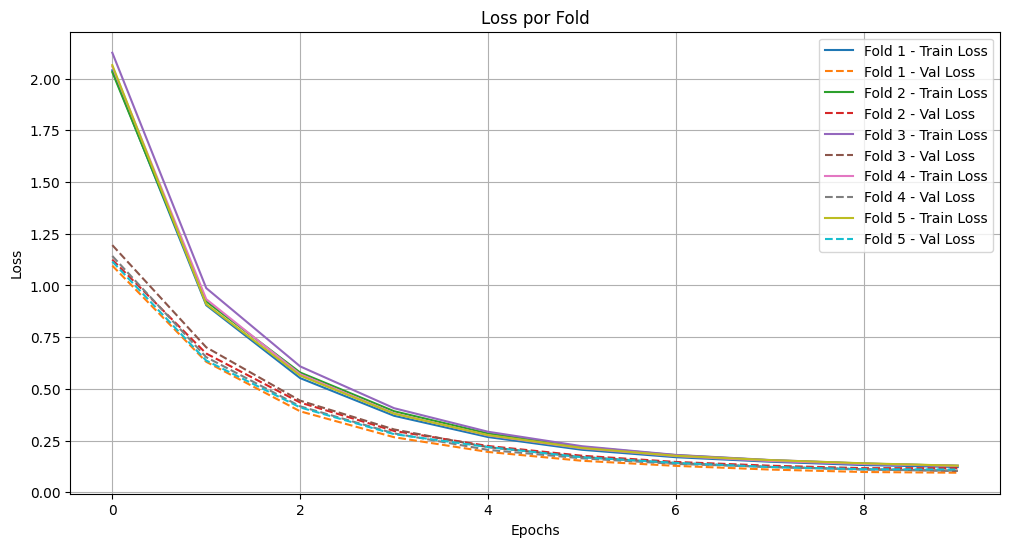

In [99]:
# 5. Graficar las métricas de cada fold
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'Fold {i+1} - Train Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'Fold {i+1} - Val Accuracy', linestyle='--')

plt.title('Accuracy por Fold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 6. Graficar las pérdidas (loss) de cada fold
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Fold {i+1} - Train Loss')
    plt.plot(history.history['val_loss'], label=f'Fold {i+1} - Val Loss', linestyle='--')

plt.title('Loss por Fold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [100]:

results = best_model.evaluate(x_test, y_test_one_hot, verbose=0)

metric_names = ['Loss', 'Accuracy']

for name, result in zip(metric_names, results):
    if name=='Loss':
        print(f"{name}: {result}")
    else:
        print(f"{name}: {result * 100:.2f}")


Loss: 0.09200876206159592
Accuracy: 98.89


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


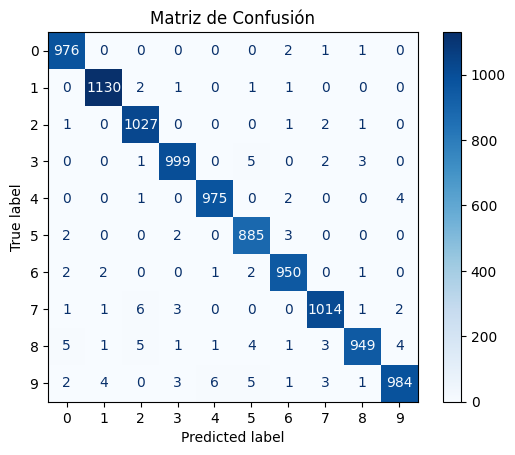

In [101]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicción
y_pred = best_model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_one_hot, axis=1)

# Matriz
cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()


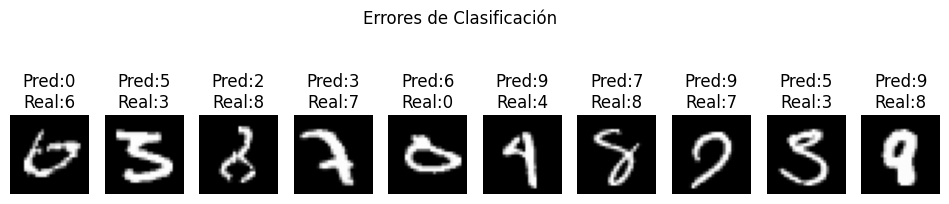

In [102]:
import numpy as np

wrong_idxs = np.where(y_pred_labels != y_true_labels)[0][:10]

plt.figure(figsize=(12, 3))
for i, idx in enumerate(wrong_idxs):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap="gray")
    plt.title(f"Pred:{y_pred_labels[idx]}\nReal:{y_true_labels[idx]}")
    plt.axis('off')
plt.suptitle("Errores de Clasificación")
plt.show()


In [103]:
def preprocess_image(image_data):
    # Open the image
    img = Image.open(io.BytesIO(image_data))
   
    # Convert to grayscale
    img = img.convert('L')
   
    # Resize to 28x28 pixels
    img = img.resize((28, 28))
   
    # Convert to numpy array
    img_array = np.array(img)
   
    # Normalize and reshape
    img_array = img_array.astype('float32') / 255
    img_array = img_array.reshape(-1, 28, 28, 1)
   
    return img_array

In [110]:
with open("imagen4.png", "rb") as file:
    img_data = file.read()
    img_array = preprocess_image(img_data)

# Make prediction
prediction = model.predict(img_array)
predicted_digit = np.argmax(prediction[0])
confidence = float(prediction[0][predicted_digit])

# Convert the image to base64 for display
image = Image.open(io.BytesIO(img_data))
buffered = io.BytesIO()
image.save(buffered, format="PNG")
img_str = base64.b64encode(buffered.getvalue()).decode()

print({
    'prediction_list': prediction,
    'prediction': int(predicted_digit),
    'confidence': confidence,
    'image': img_str
})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
{'prediction_list': array([[7.0279257e-06, 7.4403095e-01, 1.4617564e-05, 2.6876011e-04,
        2.2620493e-01, 1.5166264e-04, 5.2506806e-05, 2.6847644e-02,
        1.5987959e-03, 8.2312146e-04]], dtype=float32), 'prediction': 1, 'confidence': 0.7440309524536133, 'image': 'iVBORw0KGgoAAAANSUhEUgAAABwAAAAcCAYAAAByDd+UAAAAy0lEQVR4nO2VwQ3DIAxFTafzGB6Da6ZINmAMRuHIMUdy+z1VbQKUJE6iVsqXfMBgHjbIGCICXajHlbAqkJnJe08icgoUS4sxAgBSStmc1gwV7hB4u4wxh2aXlZSZVwVqyl4s50vL+eW6HWWfOz7V930xiJlXHWozsJXd4UARaWanBqaUsg1DCBARiAjGcTwWaK3NNmxJBdwDVQO/wZ1zs3HtJdes2GlagqIT/cZvcQNv4A3crGmargV2XUdERMMwbI7d1do0+o871OgJW27ypHj5YK0AAAAASUVORK5CYII='}


## 6. Deployment

### Exportacion en formato `.h5`

In [108]:
model.save("modelo_images.h5")

### Exportacion en formato `.keras` 

In [109]:
model.save("modelo_images.keras")